In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
from sklearn.metrics import confusion_matrix
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [4]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

In [5]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [6]:
clinton_model = bmb.Model("vote['clinton'] ~ age", clinton_data, family="bernoulli")

In [7]:
clinton_fitted = clinton_model.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Modeling the probability that vote==clinton


Compiling...


Compilation time = 0:00:01.489048


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1574.37it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1575.78it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1577.24it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1578.97it/s]


Sampling time = 0:00:01.480410


Transforming variables...


Transformation time = 0:00:00.056904


Computing Log Likelihood...


Log Likelihood time = 0:00:00.168040


In [8]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, age]


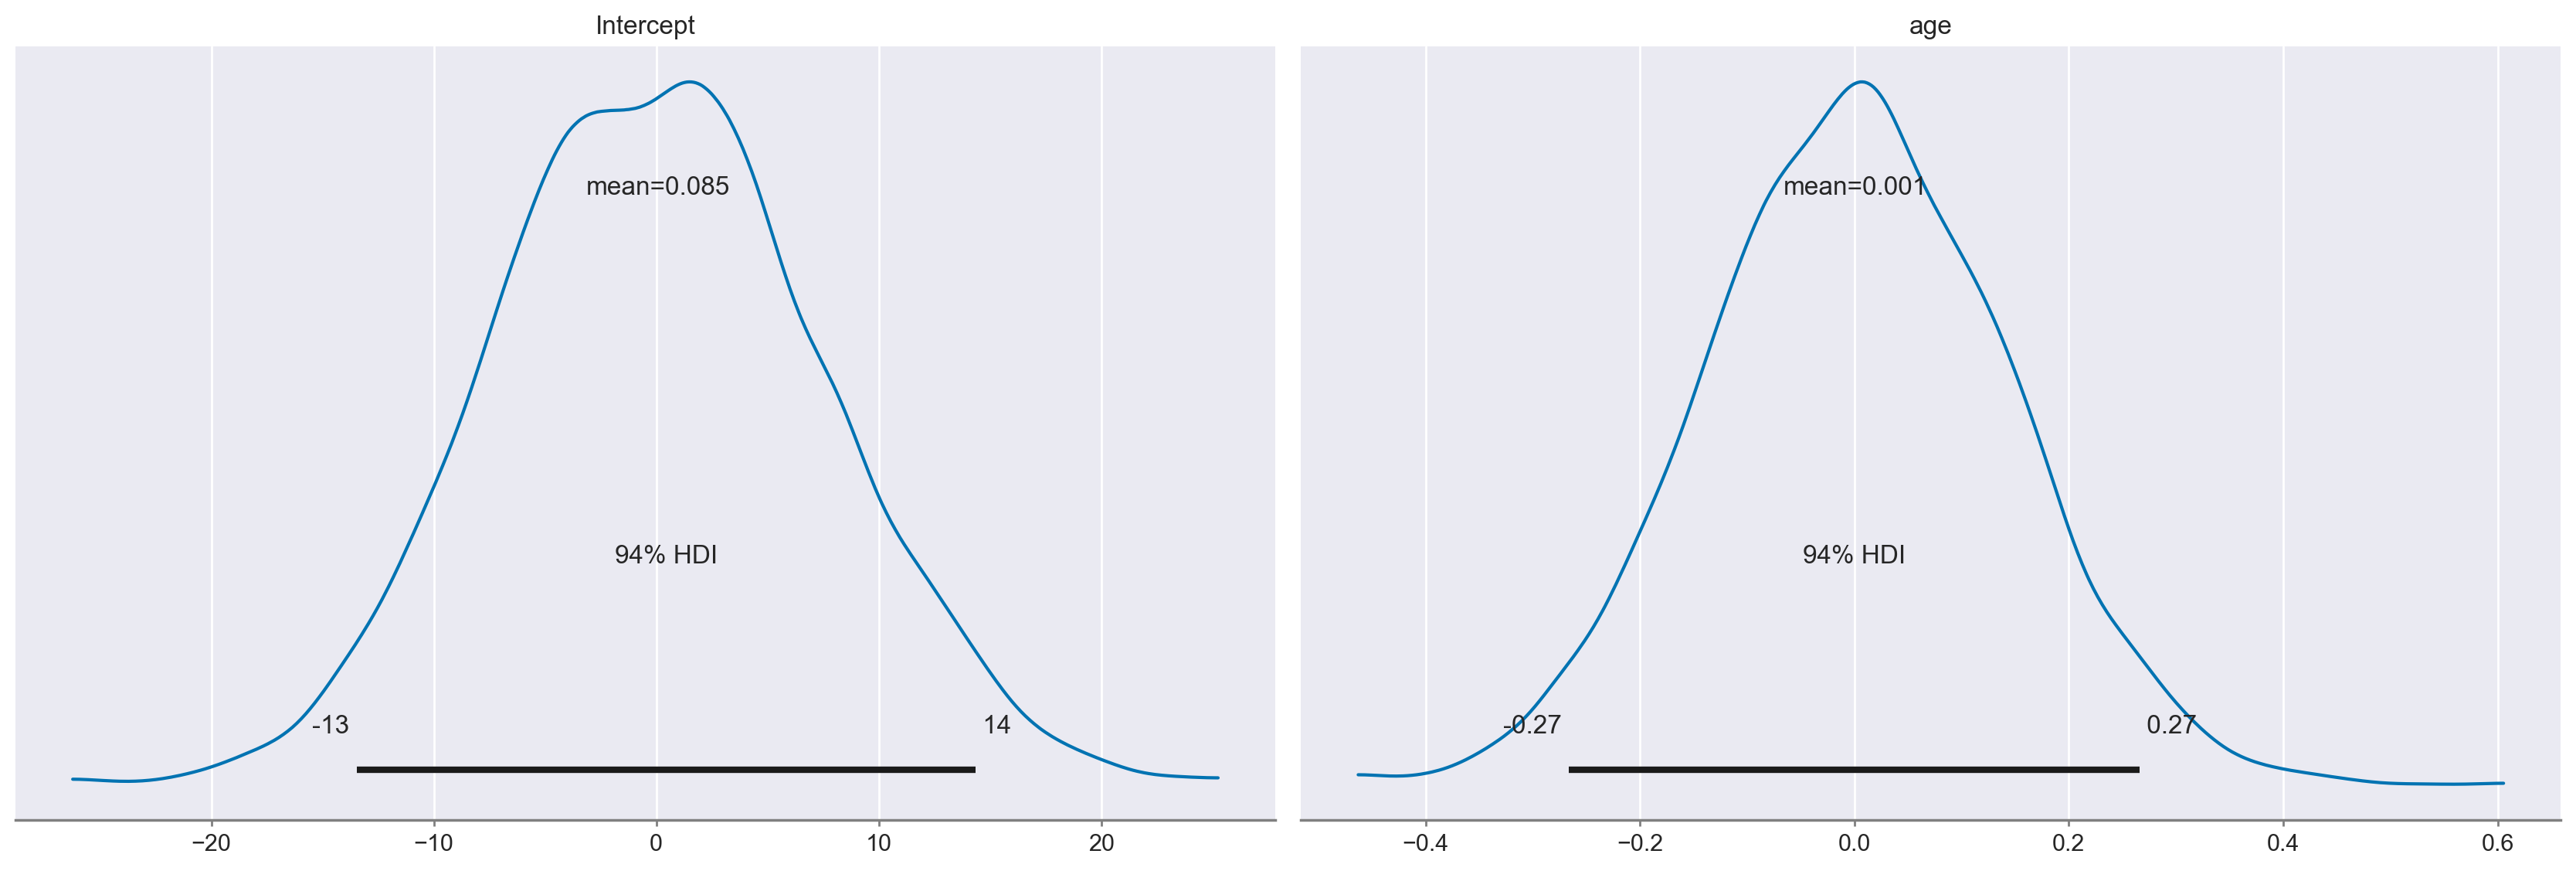

In [9]:
clinton_model.plot_priors()
plt.show()

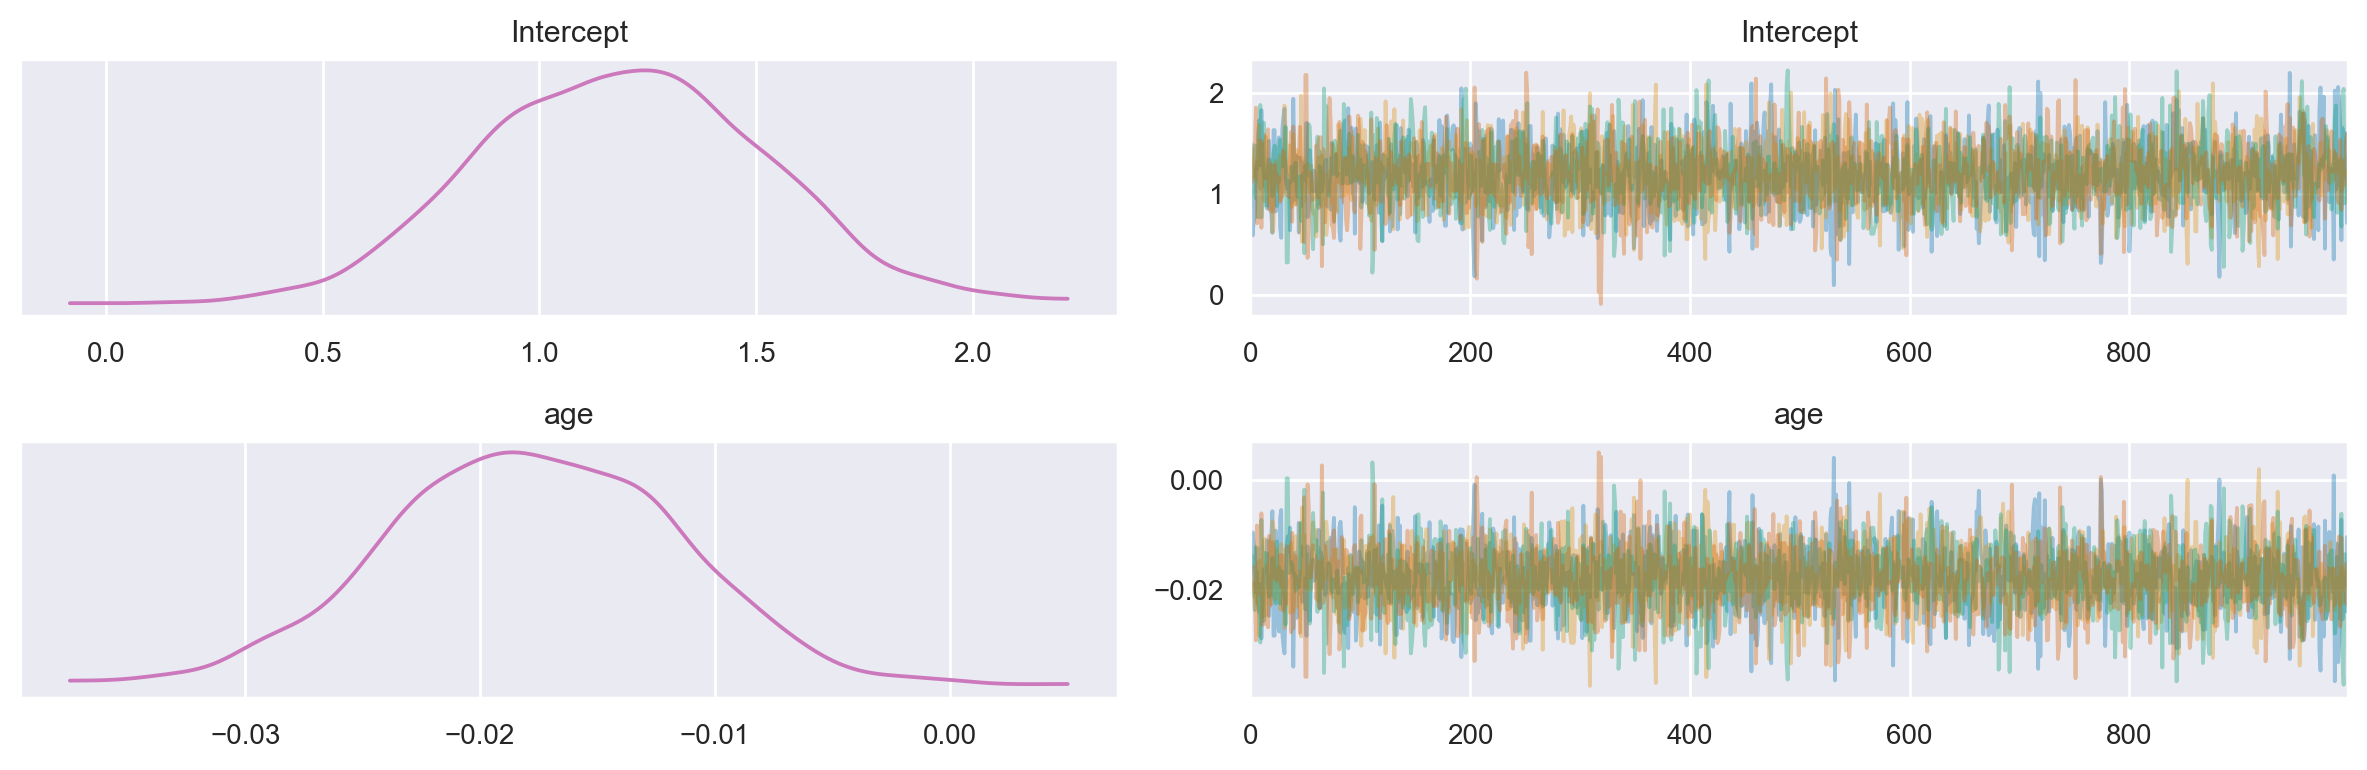

In [10]:
az.plot_trace(clinton_fitted, combined=True, compact=False)
plt.tight_layout()
plt.show()

In [11]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

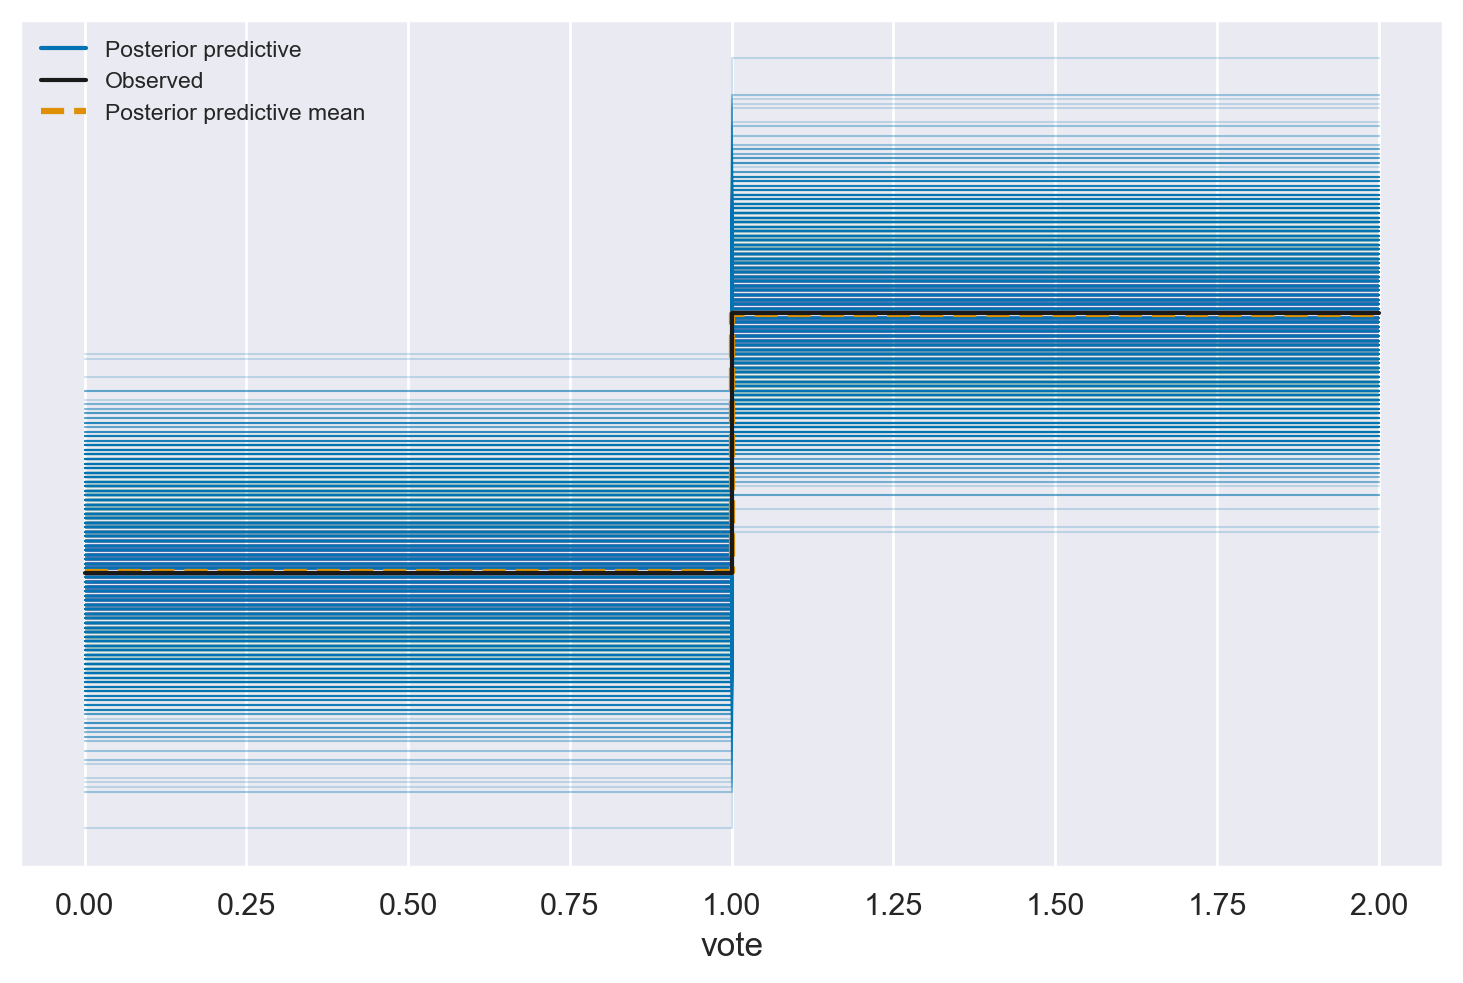

In [12]:
az.plot_ppc(clinton_fitted)
plt.show()

In [13]:
loo = az.loo(clinton_fitted, pointwise=True)

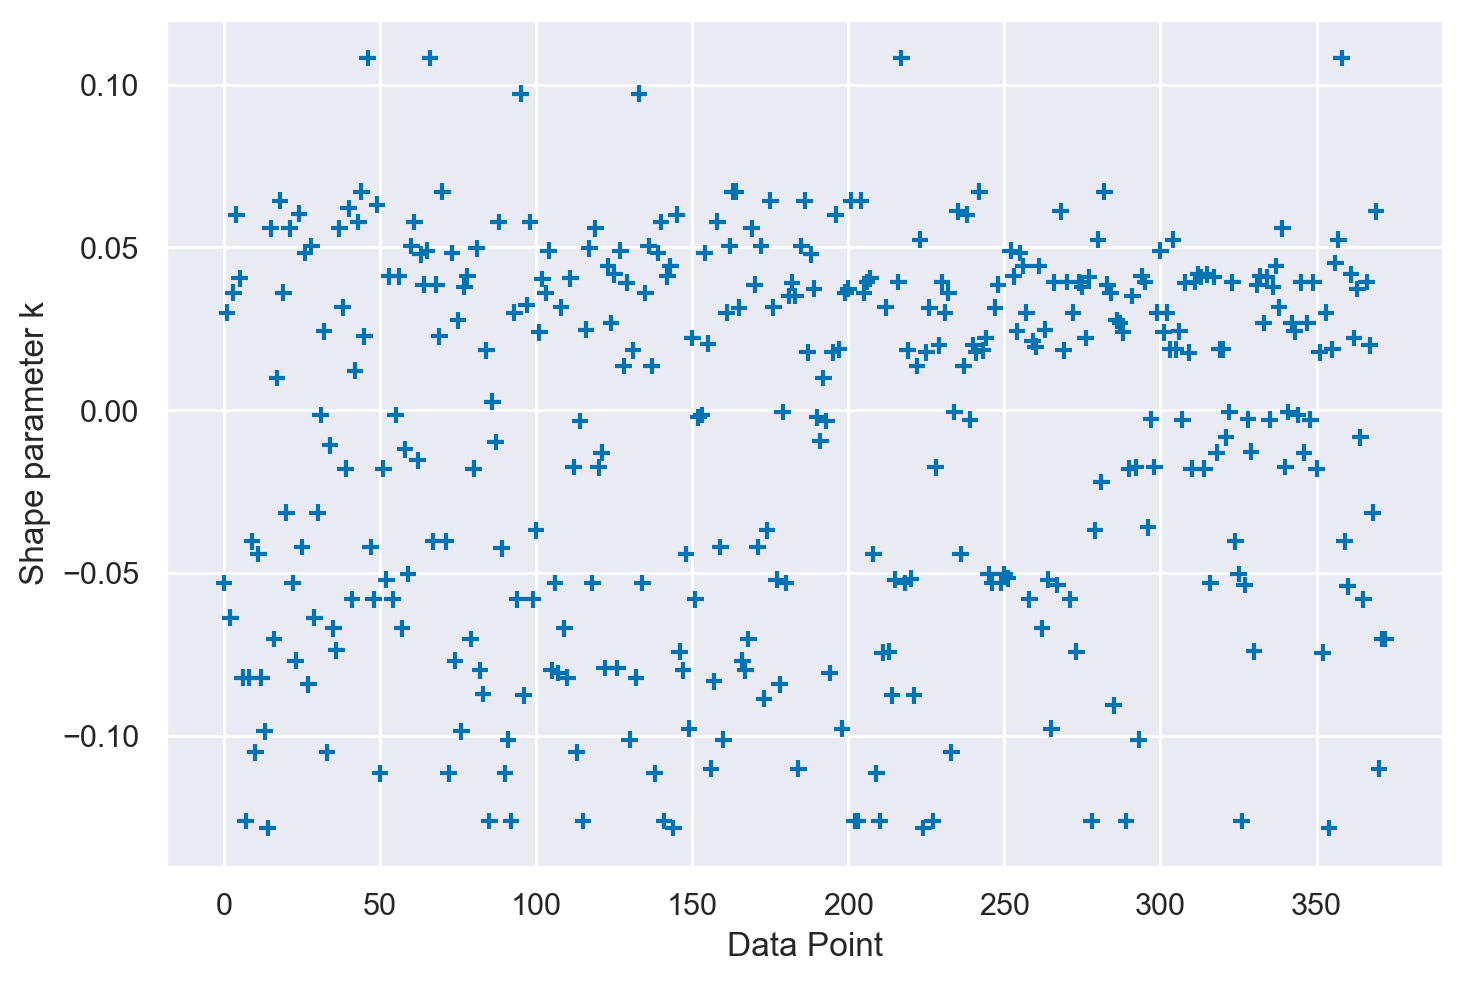

In [14]:
az.plot_khat(loo.pareto_k)
plt.show()

In [15]:
summary_df = az.summary(clinton_fitted)
print(summary_df)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       1.193  0.328   0.578    1.786      0.005    0.004    3860.0   
age            -0.018  0.006  -0.030   -0.007      0.000    0.000    4137.0   
vote_mean[0]    0.549  0.028   0.497    0.601      0.000    0.000    3259.0   
vote_mean[1]    0.509  0.035   0.442    0.576      0.001    0.000    3635.0   
vote_mean[2]    0.443  0.052   0.345    0.544      0.001    0.001    3995.0   
...               ...    ...     ...      ...        ...      ...       ...   
vote_mean[368]  0.605  0.027   0.556    0.658      0.000    0.000    3106.0   
vote_mean[369]  0.592  0.026   0.544    0.642      0.000    0.000    3064.0   
vote_mean[370]  0.513  0.034   0.448    0.577      0.001    0.000    3595.0   
vote_mean[371]  0.622  0.030   0.566    0.677      0.001    0.000    3209.0   
vote_mean[372]  0.622  0.030   0.566    0.677      0.001    0.000    3209.0   

                ess_tail  r_hat  
Intercept        

In [16]:
beta_0 = summary_df.loc['Intercept', 'mean']
print(beta_0)

1.193


In [17]:
np.exp(beta_0)

3.296957257673667

In [18]:
np.exp(beta_0) / (1 + np.exp(beta_0))

0.7672771824262011

In [19]:
beta_1 = summary_df.loc['age', 'mean']
print(beta_1)

-0.018


In [20]:
np.exp(beta_1)

0.9821610323583008

In [21]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [22]:
clinton_model.predict(clinton_fitted, data=new_data)

In [23]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

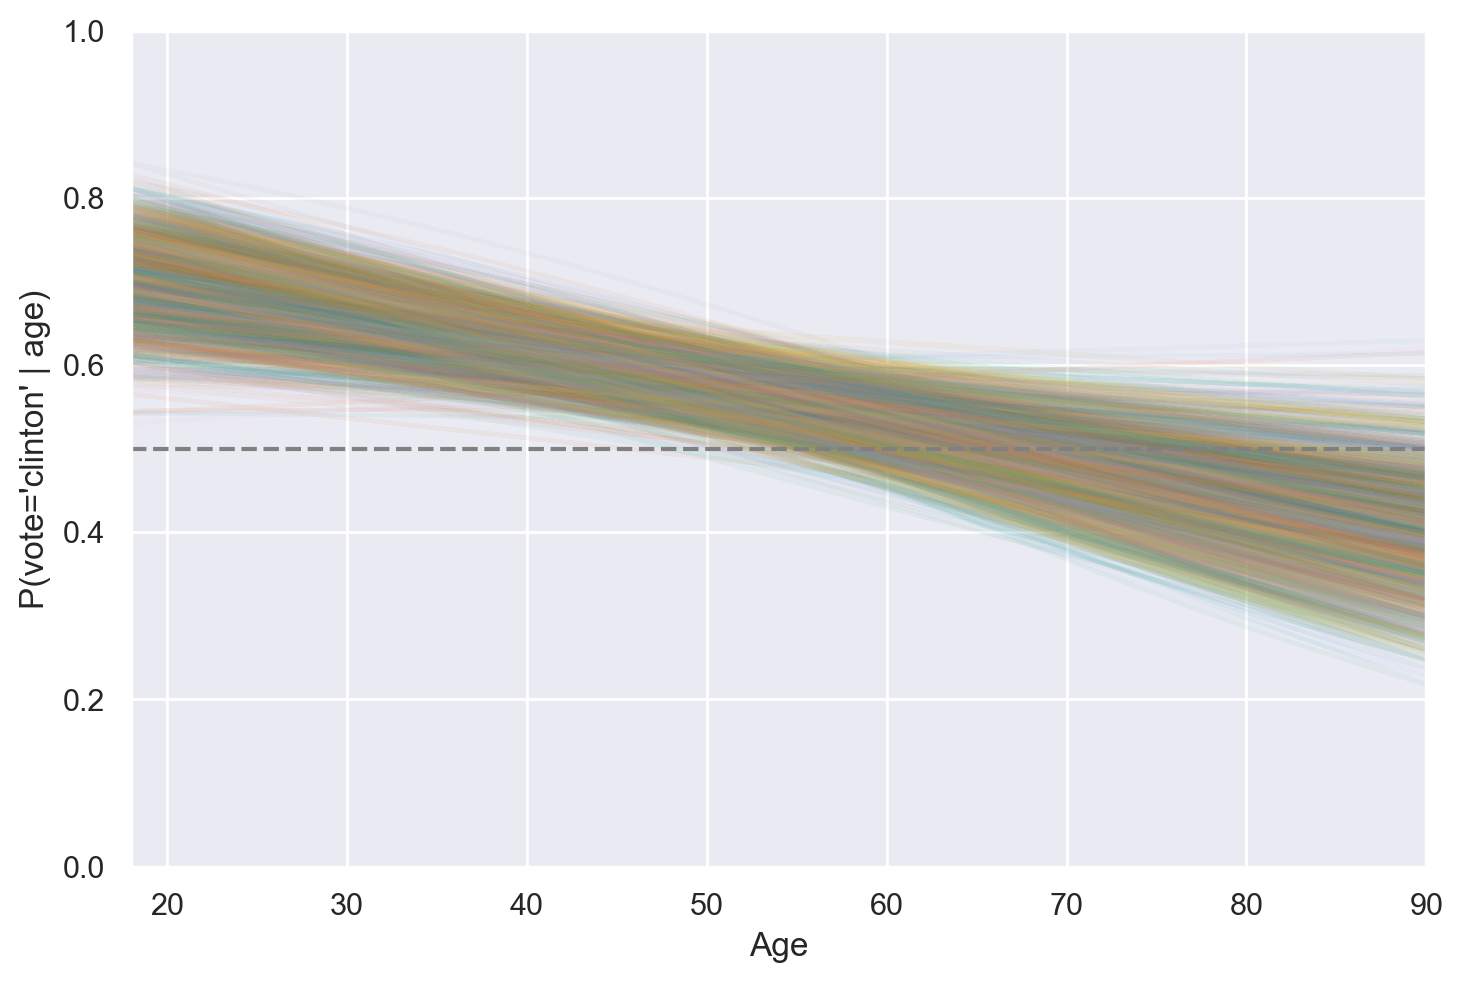

In [24]:
plt.plot(new_data.age, vote_posterior, alpha=0.05)

# Adding a dashed horizontal line at y=0.5 (50% probability)
plt.axhline(y=0.5, color="gray", linestyle="dashed")

plt.ylabel("P(vote='clinton' | age)")
plt.xlabel("Age")
plt.ylim(0, 1)
plt.xlim(18, 90);

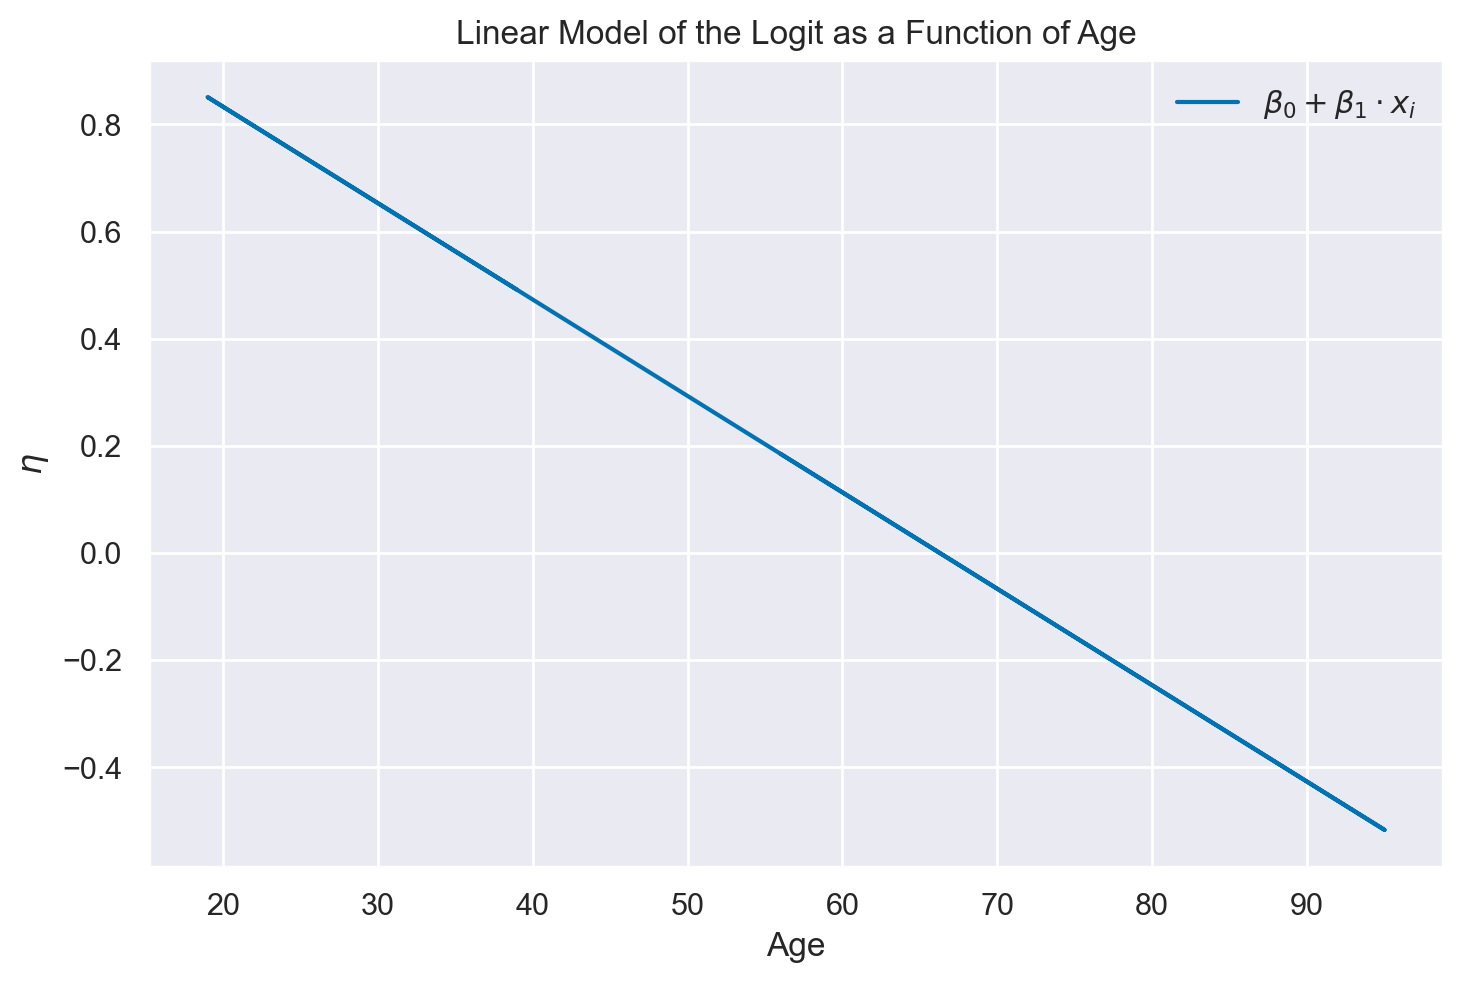

In [25]:
eta = beta_0 + beta_1 * clinton_data["age"]

plt.figure()
plt.plot(clinton_data["age"], eta, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("Age")  # Label for the x-axis
plt.ylabel(r"$\eta$")  # Label for the y-axis
plt.title("Linear Model of the Logit as a Function of Age")  # Title for the plot
plt.legend()
plt.show()

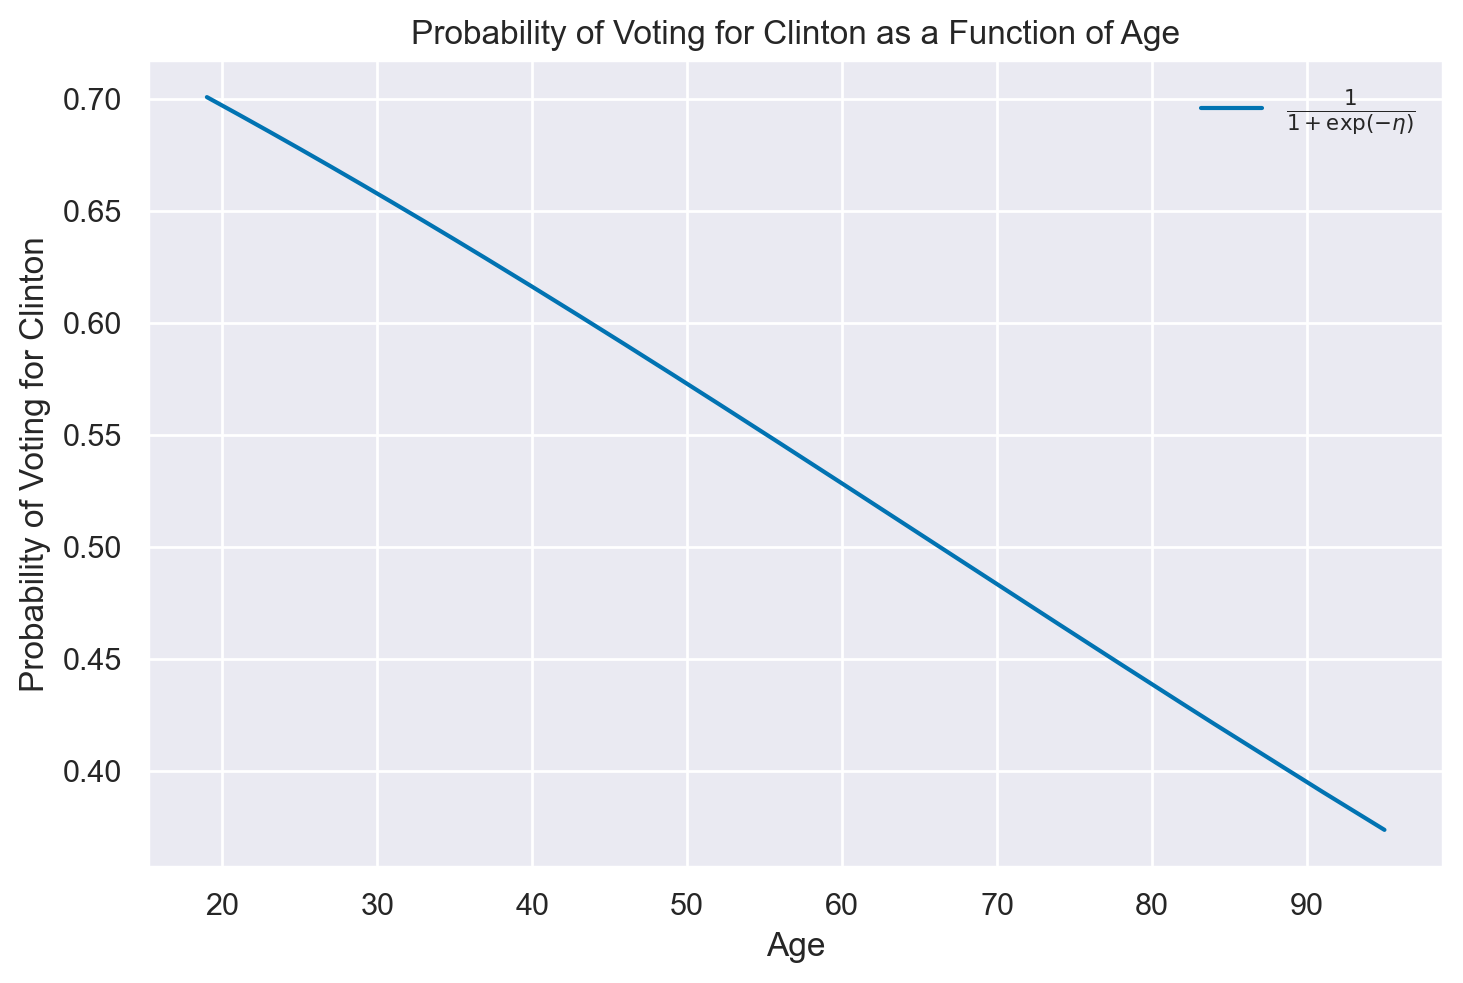

In [26]:
# Sort the age data first
sorted_age = np.sort(clinton_data["age"])

# Calculate eta using the sorted ages
eta_sorted = beta_0 + beta_1 * sorted_age

# Compute the sigmoid function
p_true_sorted = 1 / (1 + np.exp(-eta_sorted))

# Now, plot the sigmoid curve
plt.figure()
plt.plot(sorted_age, p_true_sorted, label=r"$\frac{1}{1 + \exp(-\eta)}$")
plt.xlabel("Age")
plt.ylabel(r"Probability of Voting for Clinton")  
plt.title("Probability of Voting for Clinton as a Function of Age")
plt.legend()
plt.show()

In [27]:
clinton_model.predict(clinton_fitted)

In [28]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.56101464, 0.522616  , 0.45824759, ..., 0.52690419,
         0.63125305, 0.63125305],
        [0.50757268, 0.47209886, 0.41376804, ..., 0.47603305,
         0.57408581, 0.57408581],
        [0.51432346, 0.49290285, 0.45729831, ..., 0.49528307,
         0.5545785 , 0.5545785 ],
        ...,
        [0.56510084, 0.51166859, 0.42262766, ..., 0.51764136,
         0.66114311, 0.66114311],
        [0.53339729, 0.51010846, 0.47124618, ..., 0.51270014,
         0.57691315, 0.57691315],
        [0.52912657, 0.50107206, 0.4543867 , ..., 0.5041928 ,
         0.5814808 , 0.5814808 ]],

       [[0.5049106 , 0.45278921, 0.36869374, ..., 0.45855045,
         0.60217024, 0.60217024],
        [0.57758477, 0.53233504, 0.45609958, ..., 0.53740315,
         0.65907747, 0.65907747],
        [0.51269043, 0.46496032, 0.38722515, ..., 0.47024802,
         0.60153268, 0.60153268],
...
        [0.57890104, 0.54147434, 0.47825681, ...

In [29]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

,vote,age,party_id,probs
0,clinton,56,democrat,0.548767
1,trump,65,republican,0.508991
2,clinton,80,democrat,0.443193
3,trump,38,republican,0.625864
4,trump,60,republican,0.531123


In [30]:
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);

In [31]:
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

In [32]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 28 130]
 [ 27 188]]


In [33]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

In [34]:
184/ (31+184)

0.8558139534883721

In [35]:
33 / (33+125)

0.2088607594936709

In [36]:
%run ../wtrmrk.py

Watermark:
----------
Last updated: 2024-01-26T18:49:50.264129+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


